In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import seaborn as sns
sns.set_theme(font_scale=0.8, font ='Open Sans')

from datetime import datetime

In [2]:
today = datetime.today().strftime('%Y%m%d')

In [3]:
#Import categories df
#Predicted and labelled are merged here with labelled documents only distinguishable by 'seen' == 1
cdf = pd.read_csv('data/withPredictions_minimal.csv', encoding =  'UTF-8')
print(cdf.shape)
cdf.head()

(8299, 23)


,id,title,content,PY,seen,random,include_score,2 - Adaptation,2 - Mitigation,2 - Other,...,4 - 4. Organisation,7 - International,7 - National,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post
0,505468,Community pond rehabilitation to deal with cli...,A large number of small- to medium-sized commu...,2016,NaN,NaN,0.968089,0.783095,0.003115,0.246469,...,0.959119,0.013613,0.022471,0.961818,0.039962,0.874821,0.068860,0.103273,0.619294,0.936461
1,3286707,Vulnerability to global environmental changes:...,The purpose of this paper is to demonstrate th...,2018,NaN,NaN,0.587677,0.030497,0.003366,0.003145,...,0.048519,0.001559,0.017716,0.100522,0.003420,0.005188,0.004376,0.022849,0.003031,0.012849
2,1962940,Migratory issues in climate adaptation policie...,The issue of climate change has shed a new lig...,2012,NaN,NaN,0.996653,0.851657,0.075038,0.011788,...,0.003477,0.053642,0.857579,0.003639,0.007104,0.007903,0.014083,0.123407,0.006712,0.995119
3,1047270,Women's Empowerment and Climate Change Adaptat...,(1) As on-the-ground projects come into existe...,2018,NaN,NaN,0.948534,0.622924,0.003628,0.018892,...,0.910039,0.007457,0.016662,0.070956,0.003045,0.003763,0.004649,0.016103,0.002465,0.052423
4,770190,Climatic and Environmental Changes Affecting C...,Small rural coastal communities located in Atl...,2017,NaN,NaN,0.866686,0.814135,0.004539,0.028920,...,0.060801,0.002592,0.009204,0.564695,0.891267,0.044223,0.035439,0.026959,0.008394,0.801332


In [4]:
#Let's rename so that labels by default don't have all the extra bits
renameDict = {}
for col in cdf.columns:
    if col[0].isdigit():
        renameDict[col] = re.split("[\\.|-]\\s", col)[-1].strip()

cdf.rename(renameDict, axis='columns', inplace=True)

classes =  list(renameDict.values())

cdf.columns

Index(['id', 'title', 'content', 'PY', 'seen', 'random', 'include_score',
       'Adaptation', 'Mitigation', 'Other', 'Nodality', 'Treasure',
       'Authority', 'Organisation', 'International', 'National', 'Subnational',
       'Coastal', 'Rivers', 'Terrestrial', 'Human', 'Ex-ante', 'Ex-post'],
      dtype='object')

### Some basic bar charts

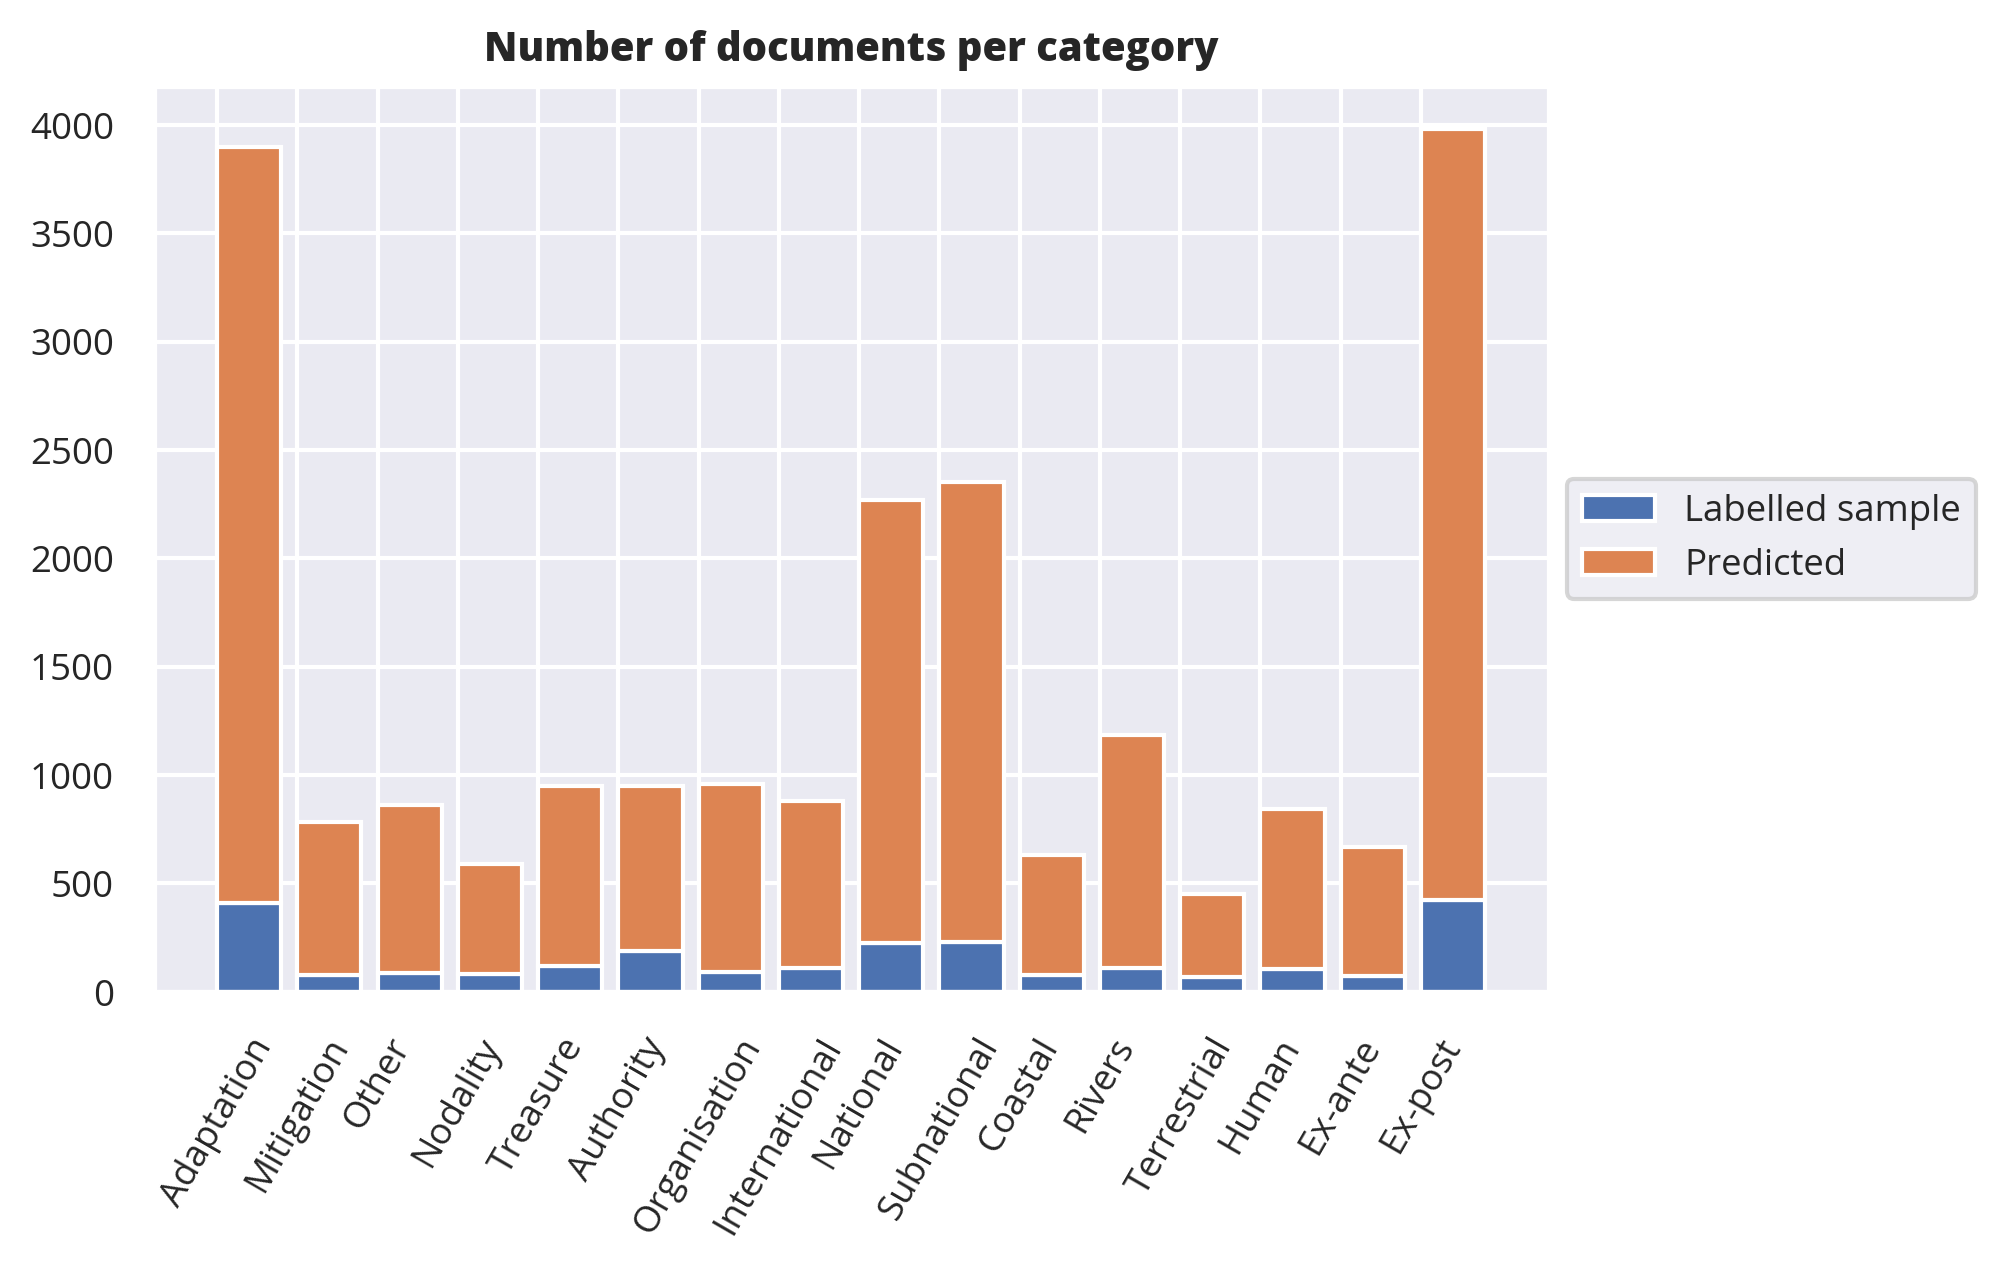

In [5]:
#Plot all classes by labelled or predicted
#Should have fairly comparable ratios for mos#
cvalues = [cdf[(cdf[c] >0.5) & (cdf['seen'].isna())].shape[0] for c in classes] #Predicted
lvalues = [cdf[(cdf[c] >0.5) & (cdf['seen'] == 1)].shape[0] for c in classes] #Labelled
fig, ax = plt.subplots(dpi=300)
plt.bar(x = classes, height = lvalues, align='edge', label='Labelled sample')
plt.bar(x = classes, height = cvalues, align='edge', label = 'Predicted',  bottom=lvalues)
plt.xticks(rotation=60)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Number of documents per category", weight='bold')
fig.patch.set_facecolor("white")
plt.show()

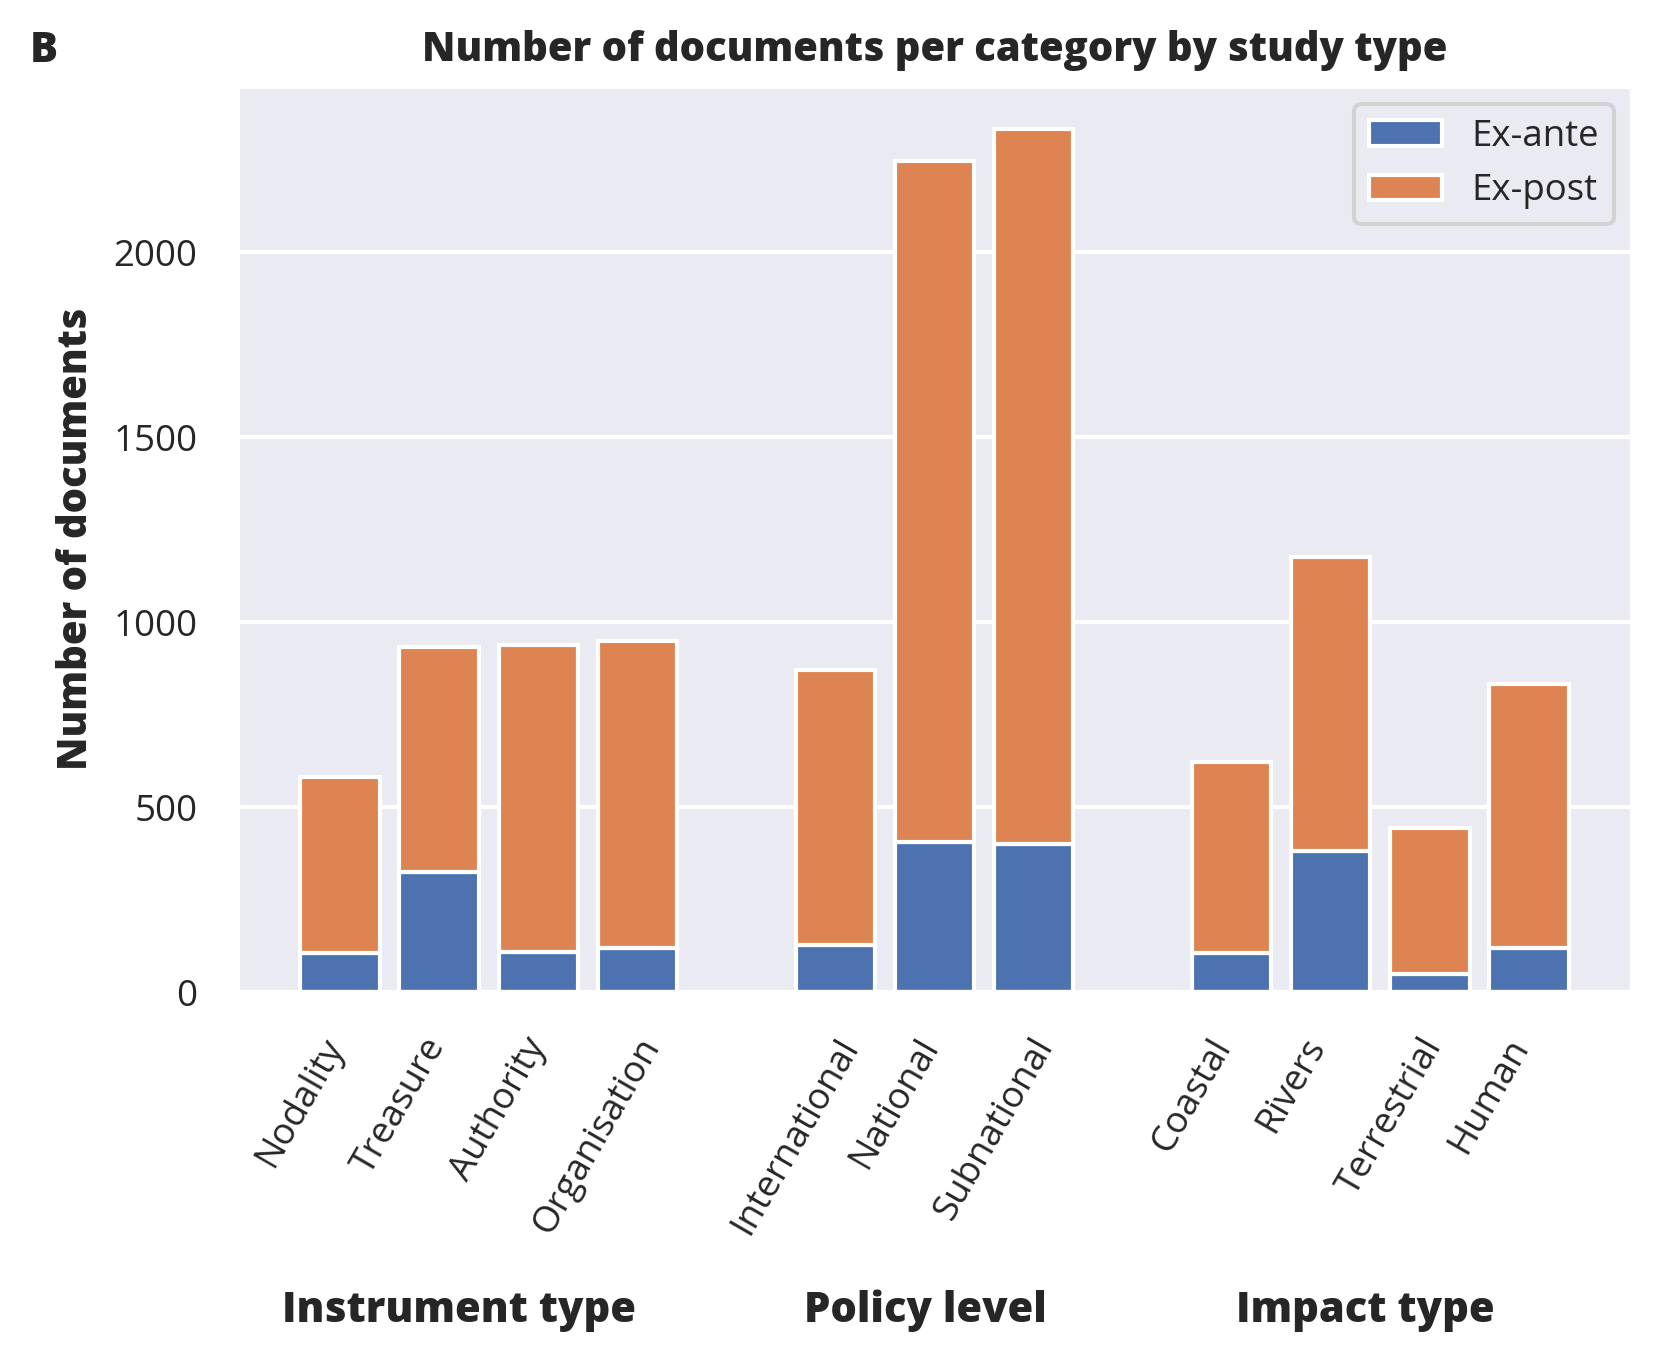

In [6]:
#Same but stacking ex-ante vs ex-post + adaptation/mitigation/other removed as we can show that info in the plot below
classes2 =  [c for c in classes if c not in ['Ex-ante', 'Ex-post', 'Adaptation', 'Mitigation', 'Other']]
avalues = [cdf[(cdf[c] >0.5) & (cdf['Ex-ante'] > cdf['Ex-post'])].shape[0] for c in classes2] #Predicted
pvalues = [cdf[(cdf[c] >0.5) & (cdf['Ex-post'] > cdf['Ex-ante'])].shape[0] for c in classes2] #Labelled

#Want to group classes together, so set x locations
xlocs =  [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12]

fig, ax = plt.subplots(dpi=300)

plt.bar(x = xlocs, height = avalues, align='edge', label='Ex-ante')
plt.bar(x = xlocs, height = pvalues, align='edge', label = 'Ex-post',  bottom=avalues)

plt.xticks(xlocs, classes2, rotation=60)
ax.grid(visible=False, axis='x')

plt.ylabel("Number of documents", weight="bold")
fig.text(0.15, -0.15, "Instrument type", weight="bold", ma='center')
fig.text(0.44, -0.15, "Policy level", weight="bold", ma='center')
fig.text(0.68, -0.15, "Impact type", weight="bold", ma='center')

plt.legend(loc='upper right')
ax.set_title("Number of documents per category by study type", weight='bold')

fig.text(0.01, 0.9, "B", weight='bold')

fig.patch.set_facecolor("white")

fig.savefig(r"Out/CategoriesBar.png", dpi=300)

plt.show()

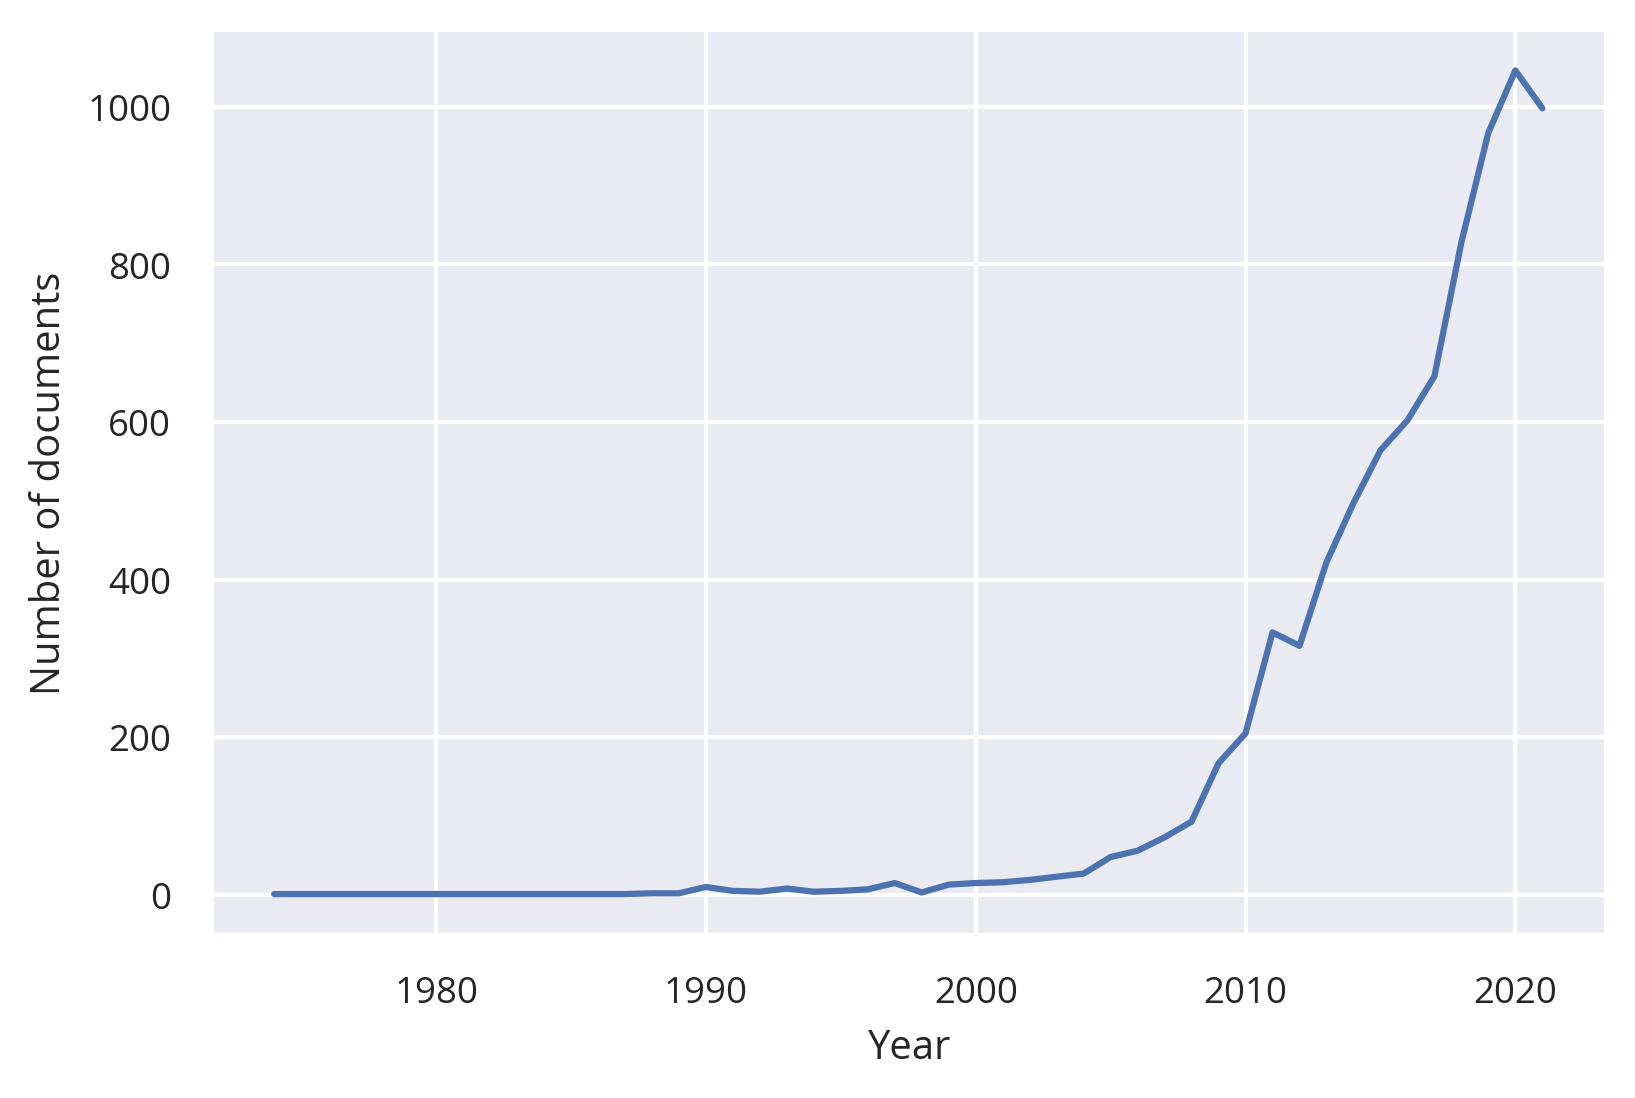

In [7]:
#Now let's try changes over time
#Year was filled with 0 for the NA's but that's obviously not great
cdf.loc[cdf['PY'] == 0, 'PY'] = np.nan

fig, ax = plt.subplots(dpi=300)
ax = cdf[cdf['PY'] <2022].groupby('PY').size().plot.line( xlabel='Year', ylabel='Number of documents',)

In [8]:
def categoriesPerYear(cats, cdf=cdf, minimum = 0.5, removeLast = True):
    #Add a column with the highest predicted category of all input categories
    cdf['MaxCat'] = cdf[cats].idxmax(axis=1)
    cdf.loc[~cdf[cats].gt(minimum).any(axis=1), 'MaxCat'] = 'No prediction'
    
    #Create a df with a column for each input category and their counts per year
    ydf= pd.DataFrame(columns= cats + ['PY', 'No prediction'])
    for y in cdf["PY"].unique():
        counts = cdf[cdf['PY'] ==y]['MaxCat'].value_counts()
        add = {l: counts[l] for l in counts.index}
        if np.isnan(y):
            add['PY'] = y
        else:
            add['PY'] = int(y)
        ydf = ydf.append(add, ignore_index=True)
        
    #last year is incomplete
    if removeLast:
        ydf = ydf[ydf['PY'] < cdf['PY'].max()]
    
    return(ydf.sort_values('PY').reset_index(drop=True))

ydf = categoriesPerYear(['Subnational', 'National', 'International'])
ydf.head()

,Subnational,National,International,PY,No prediction
0,NaN,NaN,NaN,1974,1
1,1,NaN,NaN,1987,NaN
2,NaN,NaN,NaN,1988,2
3,1,NaN,NaN,1989,1
4,1,2,NaN,1990,7


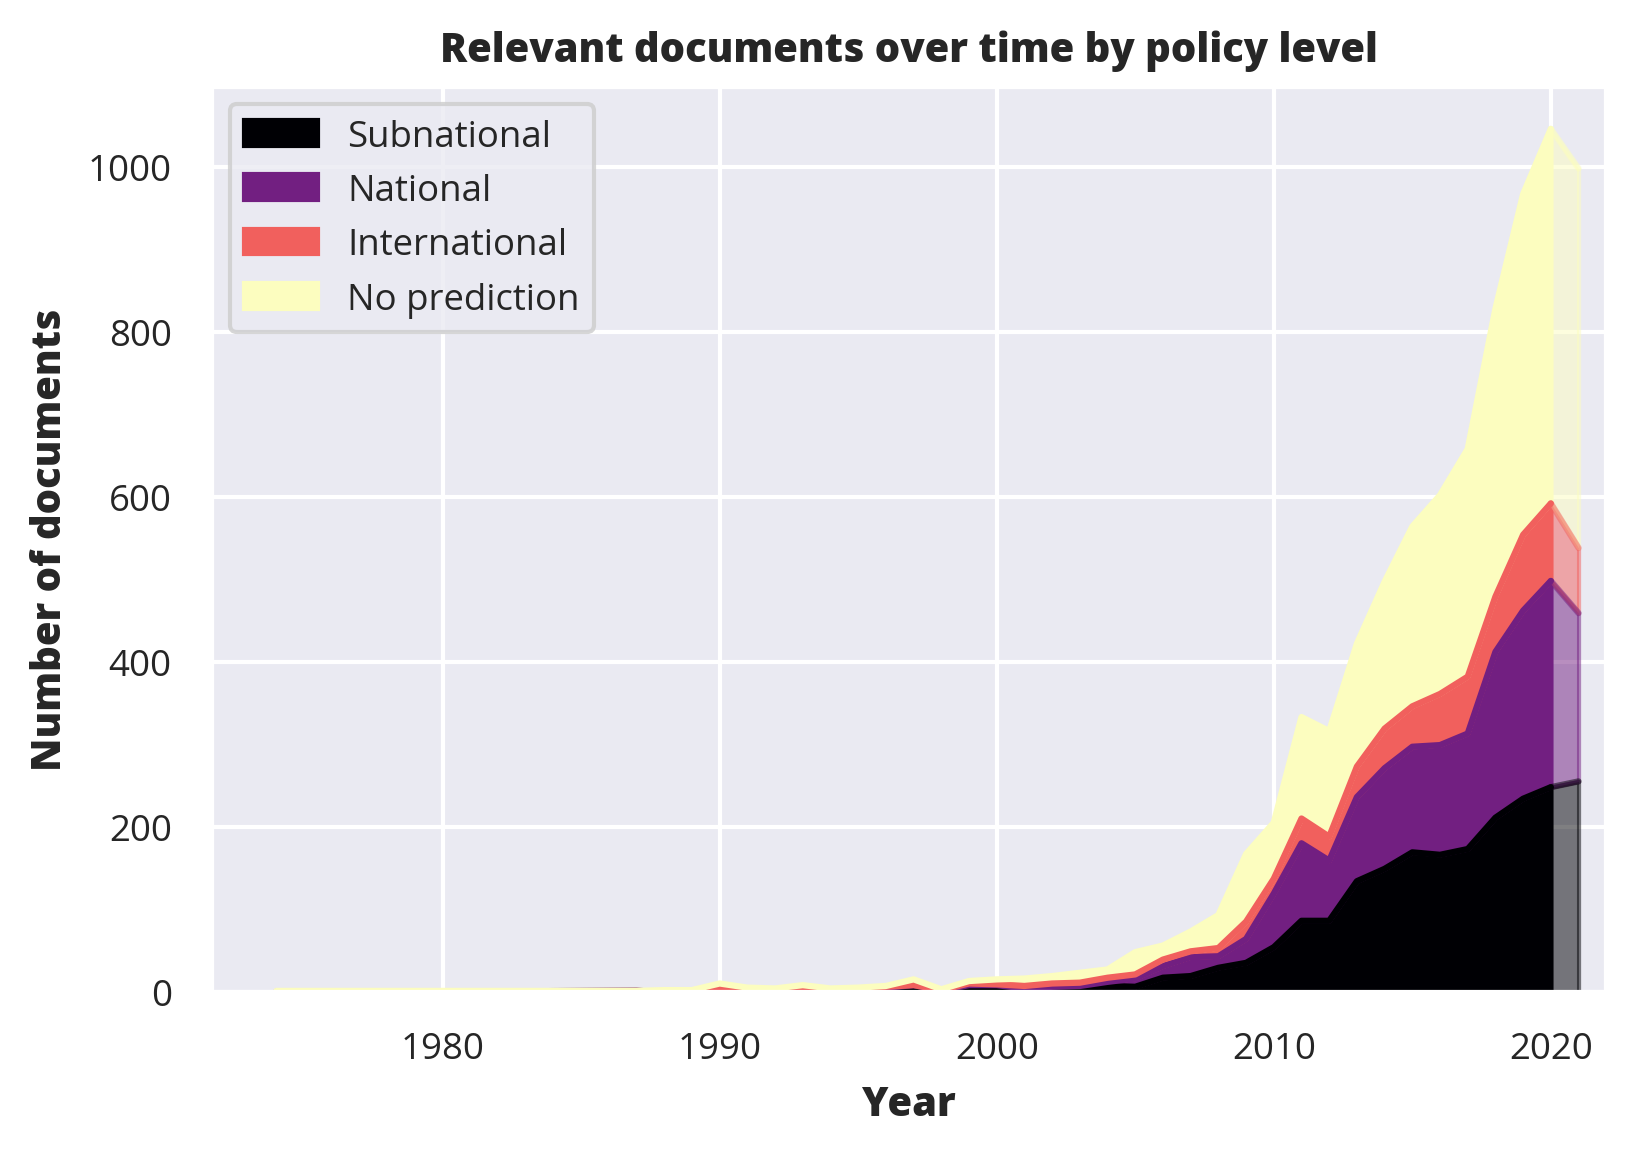

In [9]:
ydf = categoriesPerYear(['Subnational', 'National', 'International'])
fig, ax = plt.subplots(dpi=300)
ax = ydf[ydf["PY"] < 2021].plot.area(x = 'PY', colormap = 'magma', ax=ax)
ax = ydf[ydf["PY"] >= 2020].plot.area(x = 'PY', legend=False, colormap = 'magma', alpha= 0.5, ax=ax)

ax.set_title("Relevant documents over time by policy level", weight='bold')
ax.set_xlim(right=2022)
plt.xlabel("Year", weight="bold")
plt.ylabel("Number of documents", weight="bold")

fig.patch.set_facecolor("white")

ax

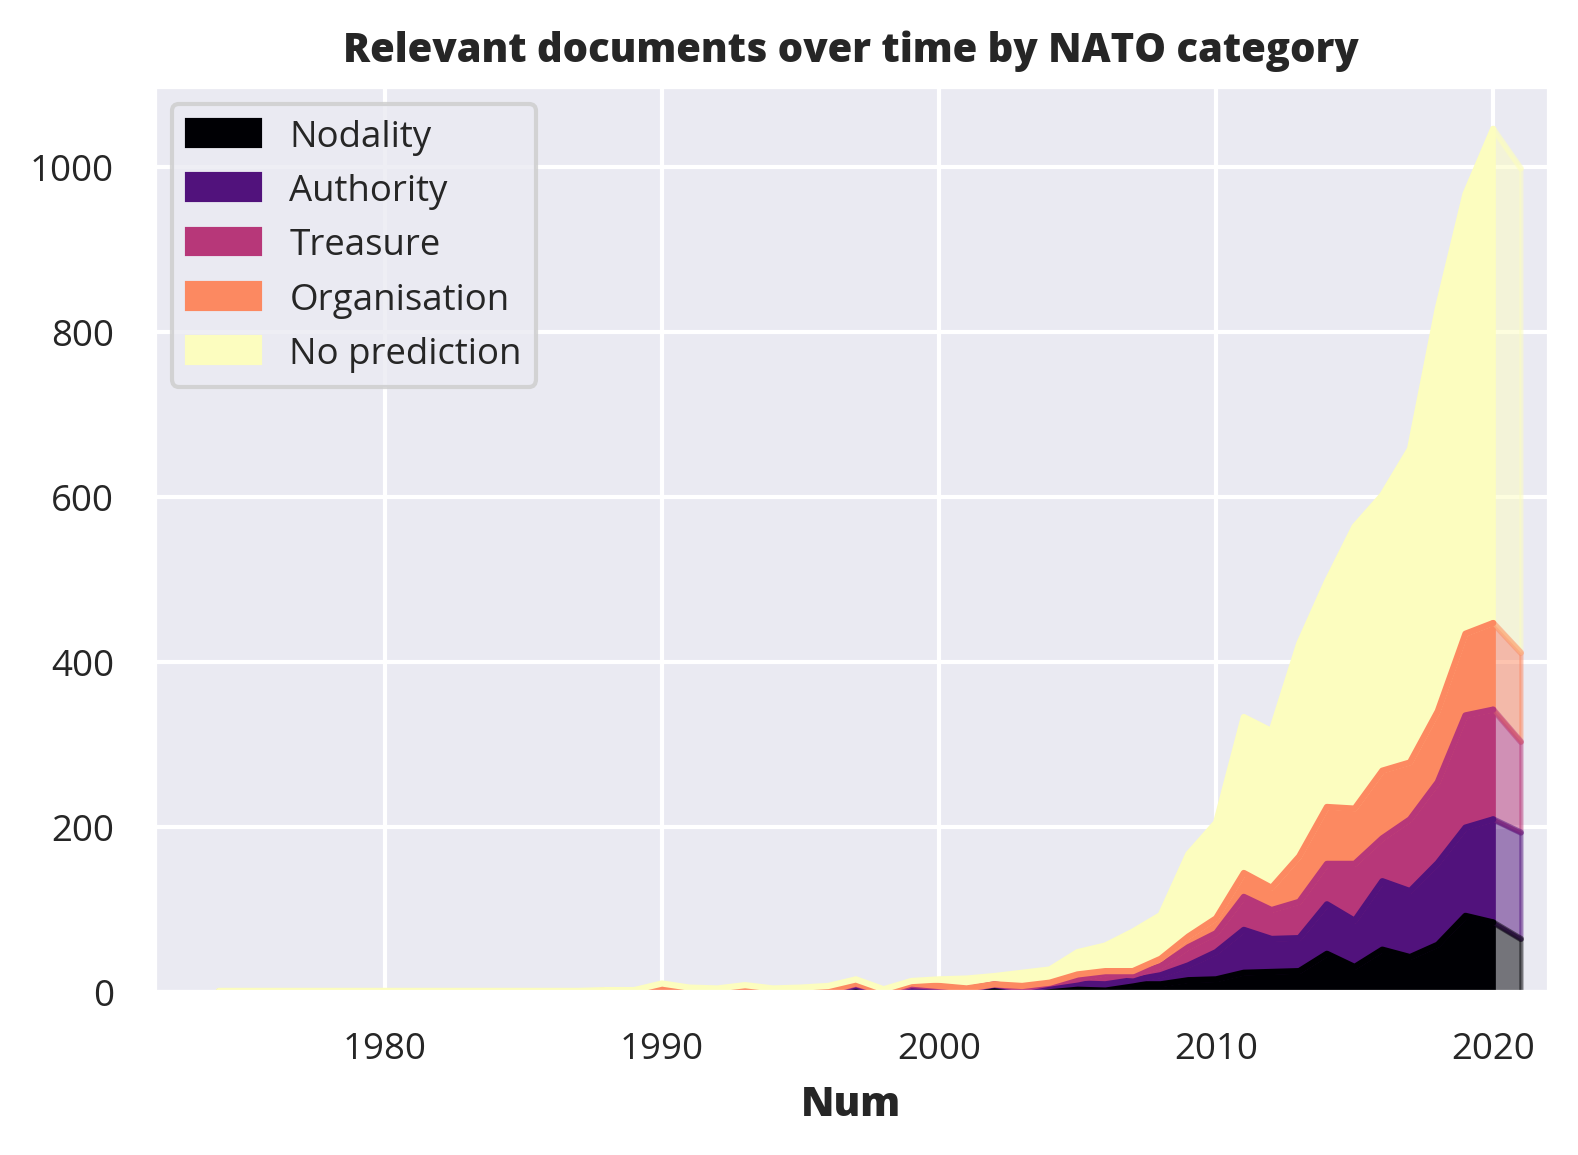

In [10]:
ydf = categoriesPerYear(['Nodality', 'Authority', 'Treasure', 'Organisation'],
                        minimum = 0.35)

fig, ax = plt.subplots(dpi=300)
ax = ydf[ydf["PY"] < 2021].plot.area(x = 'PY', colormap = 'magma', ax=ax)
ax = ydf[ydf["PY"] >= 2020].plot.area(x = 'PY', legend=False, colormap= 'magma', alpha= 0.5, ax=ax)

ax.set_title("Relevant documents over time by NATO category", weight='bold')

ax.set_xlim(right=2022)
plt.xlabel("Num", weight="bold")

fig.patch.set_facecolor("white")
ax

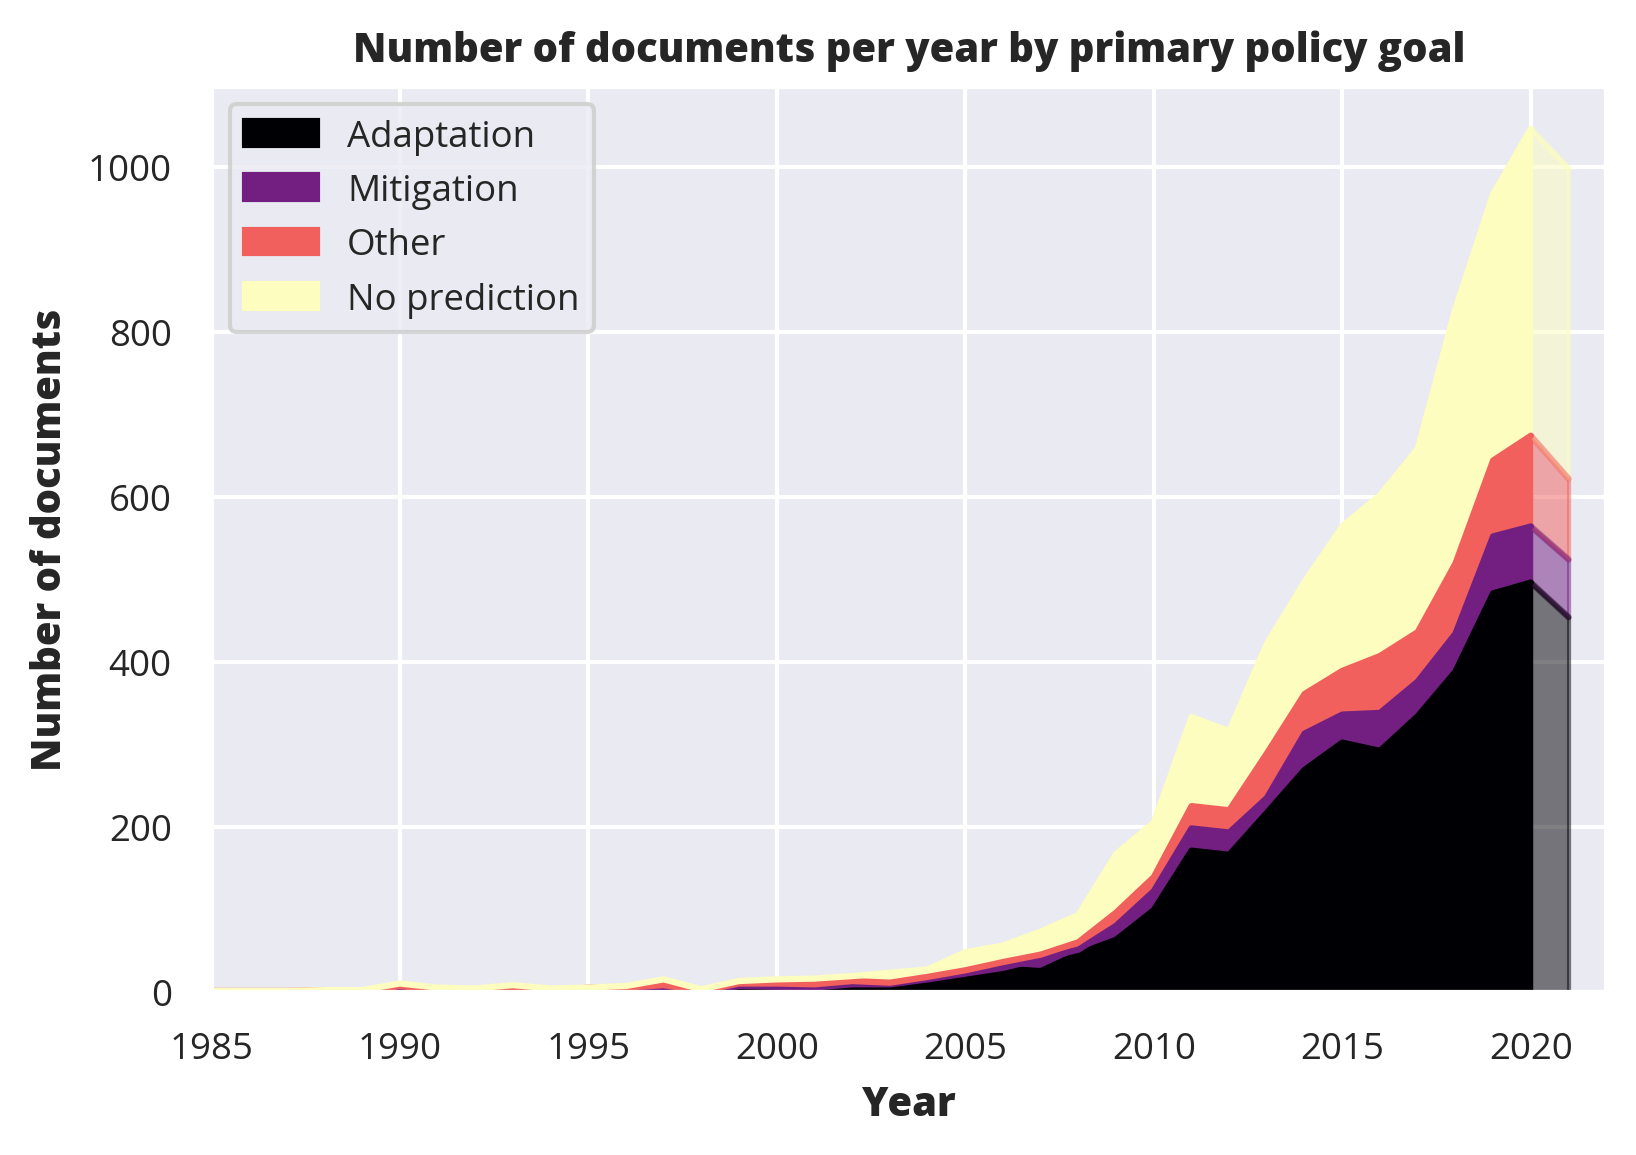

In [11]:
ydf = categoriesPerYear(['Adaptation', 'Mitigation', 'Other'],
                        minimum = 0.35)

fig, ax = plt.subplots(dpi=300)
ax = ydf[ydf["PY"] < 2021].plot.area(x = 'PY', colormap = 'magma', ax=ax)
ax = ydf[ydf["PY"] >= 2020].plot.area(x = 'PY', legend=False, colormap= 'magma', alpha= 0.5, ax=ax)

ax.set_title("Number of documents per year by primary policy goal", weight='bold')

ax.set_xlim(left = 1985, right=2022)
plt.xlabel("Year", weight="bold")
plt.ylabel("Number of documents", weight="bold")

fig.patch.set_facecolor("white")


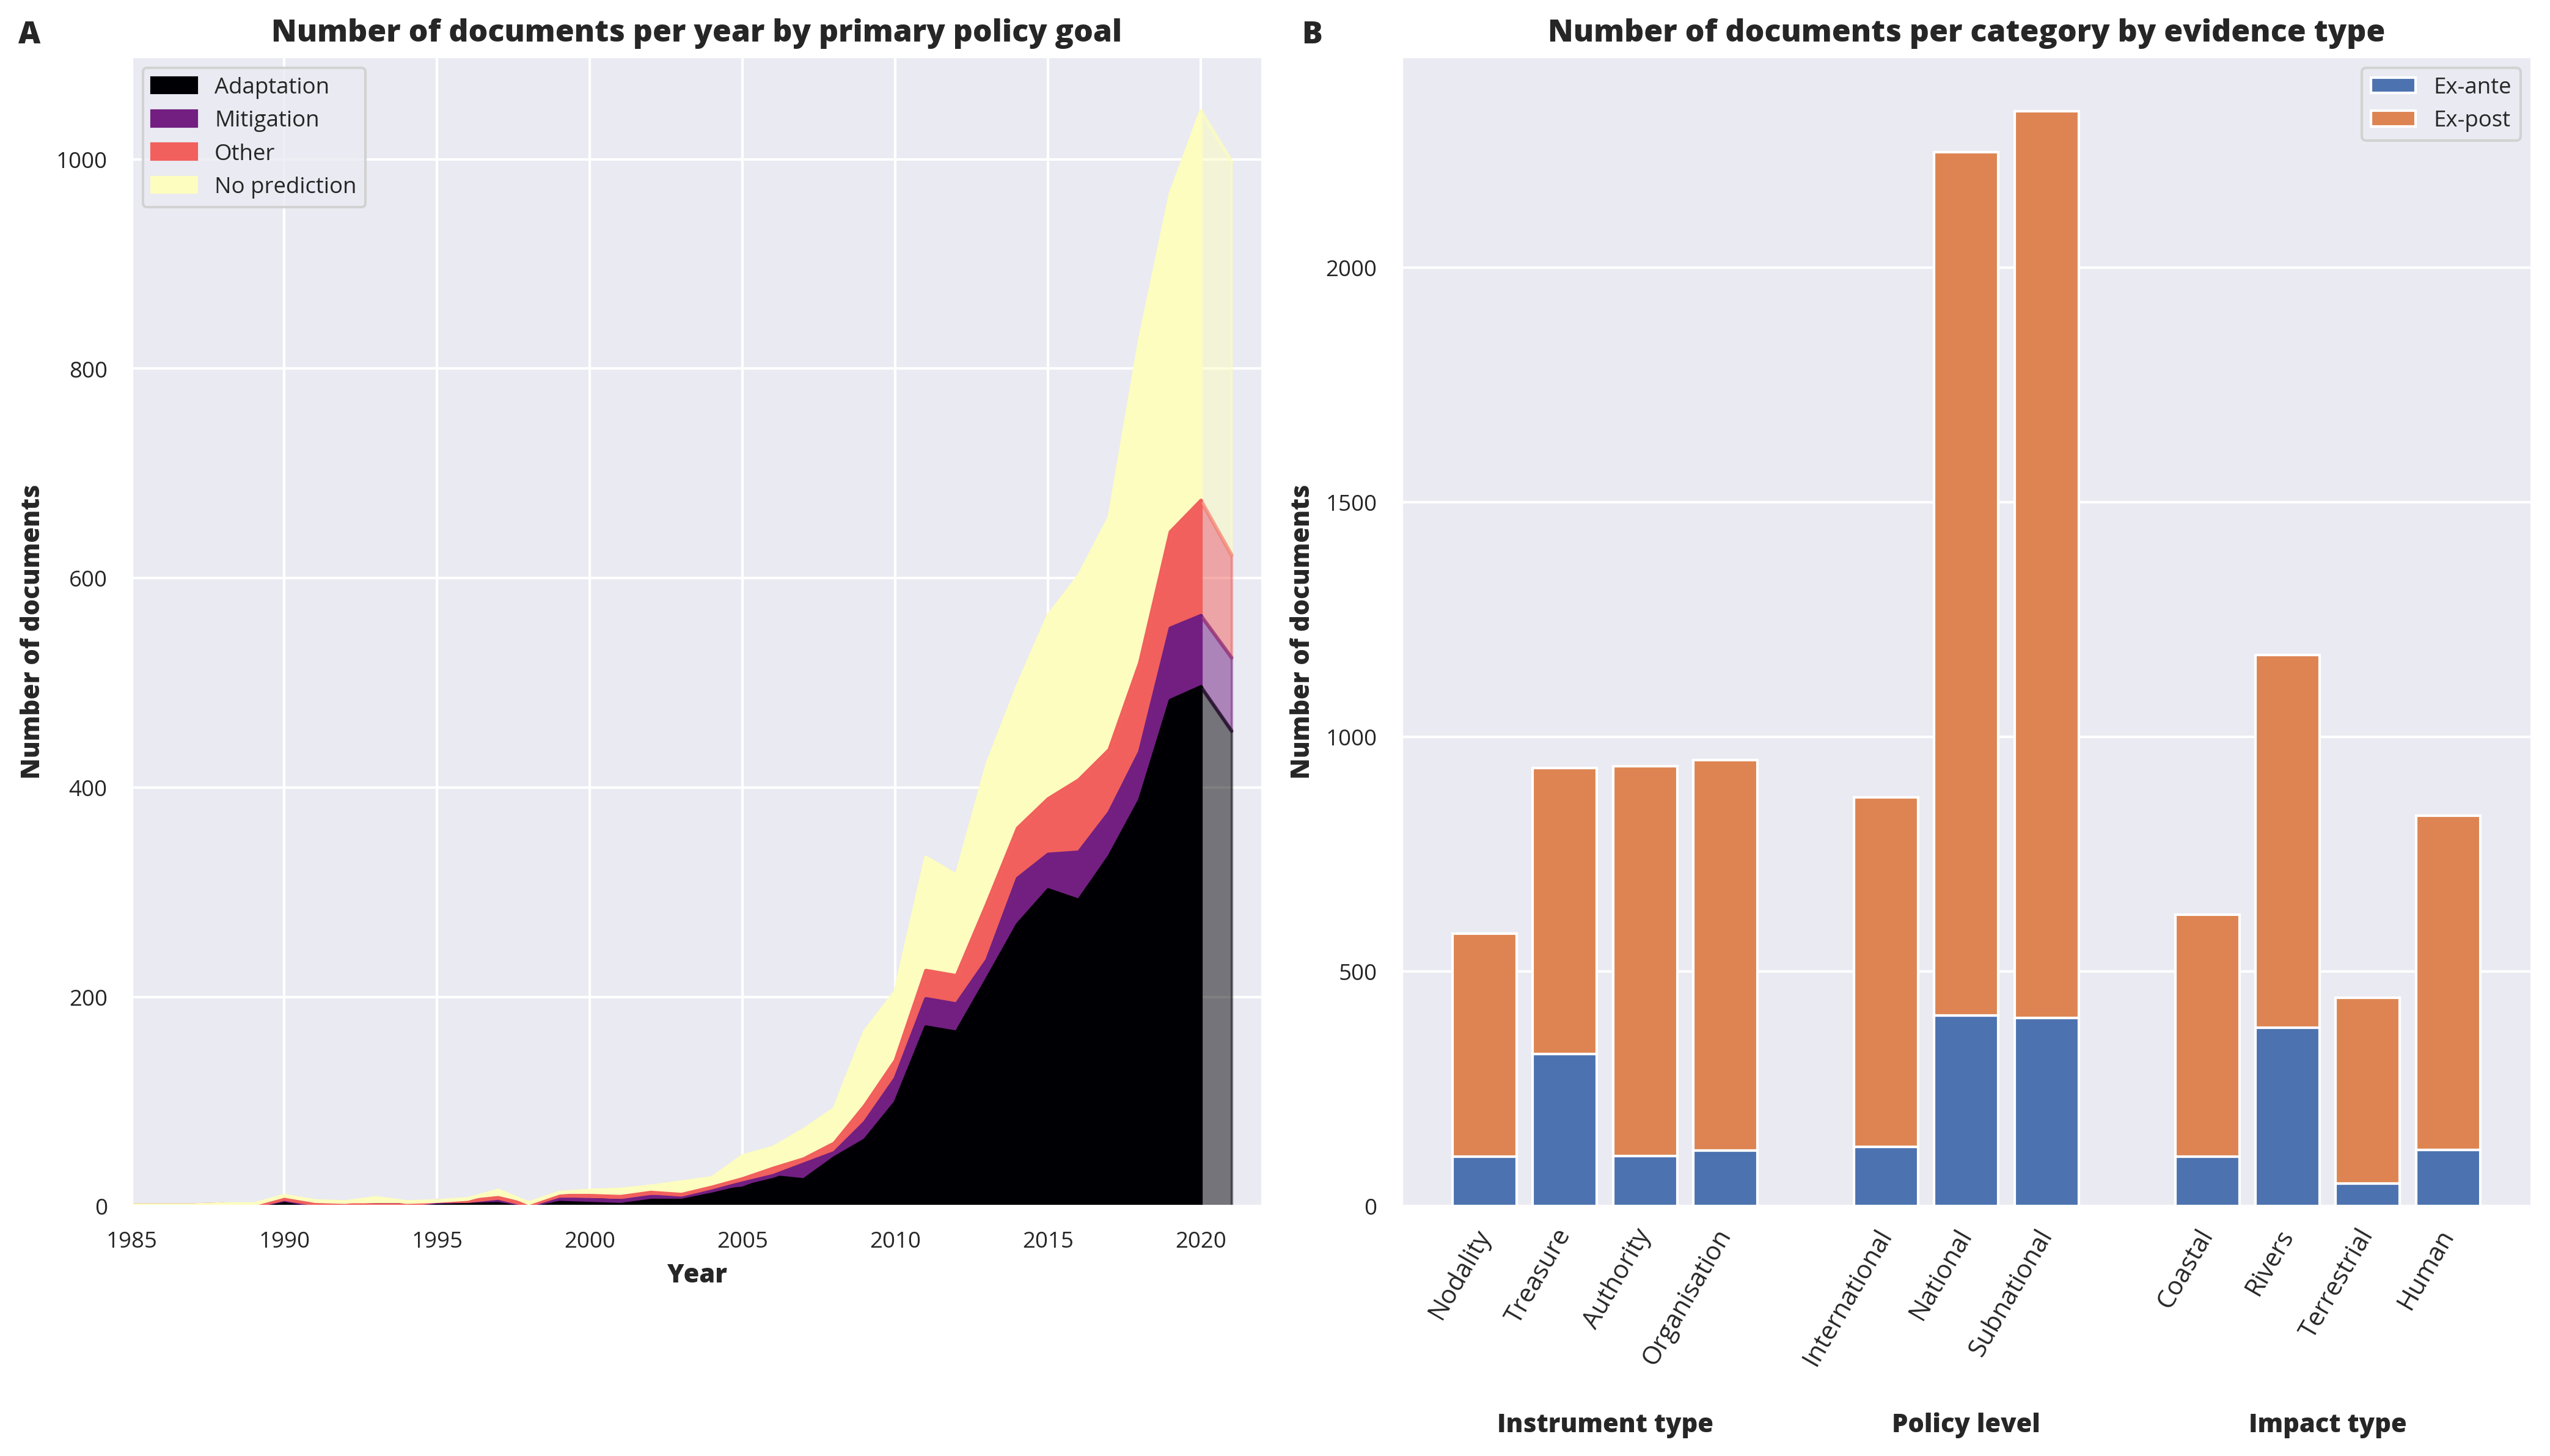

In [12]:
#Combined figure
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(14, 8), dpi =300)

ydf = categoriesPerYear(['Adaptation', 'Mitigation', 'Other'],
                        minimum = 0.35)

ax1 = ydf[ydf["PY"] < 2021].plot.area(x = 'PY', colormap = 'magma', ax=ax1)
ax1 = ydf[ydf["PY"] >= 2020].plot.area(x = 'PY', legend=False, colormap= 'magma', alpha= 0.5, ax=ax1)

ax1.set_title("Number of documents per year by primary policy goal", weight='bold', size=12)

ax1.set_xlim(left = 1985, right=2022)
ax1.set_xlabel("Year", weight="bold", size=10,)
ax1.set_ylabel("Number of documents", weight="bold", size=10)

#Second figure
xlocs =  [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12]
ax2.bar(x = xlocs, height = avalues, align='center', label='Ex-ante', width = 0.8)
ax2.bar(x = xlocs, height = pvalues, align='center', label = 'Ex-post',  bottom=avalues, width=0.8)

ax2.set_xticks(xlocs)
ax2.set_xticklabels(classes2, rotation=60, rotation_mode='anchor', ha='right', va='center', size=10,)
ax2.grid(visible=False, axis='x')

ax2.set_ylabel("Number of documents", weight="bold", size=10)
ax2.text(1.5, -480, "Instrument type", size=10, weight="bold", ha='center') #Locations are in coordinates
ax2.text(6, -480, "Policy level", size=10, weight="bold", ha='center')
ax2.text(10.5, -480, "Impact type", size=10, weight="bold", ha='center')

plt.legend(loc='upper right')
ax2.set_title("Number of documents per category by evidence type", weight='bold', size=12)

fig.text(0.01, 0.98, "A", weight='bold', va='top', size=12)
fig.text(0.51, 0.98, "B", weight='bold', va='top', size = 12)

fig.patch.set_facecolor("white")

fig.tight_layout()
fig.savefig(r"Out/CategoriesBar.png", dpi=300)

plt.show()

## Heatmaps

In [13]:
#Create a numpy array which can be used to create heatmaps
def createGrid(xclasses, yclasses, cdf=cdf):
    grid = np.zeros((len(xclasses), len(yclasses)))
    for i, col in enumerate(xclasses):
        for j, row in enumerate(yclasses): 
            if row != col:
                #Select where the predicted relevance for both classes is >5
                grid[i, j] = cdf[(cdf[row] > 0.5) & (cdf[col] >0.5)].shape[0]
                
    return(grid)

In [14]:
#Normalise either by row or by column
def normaliseGrid(grid, axis = 0, percentage=True, mask = None):
    if type(mask) == np.ndarray: #Input as np array of same dimensions where any set to True will be masked
        grid = np.ma.MaskedArray(grid, mask)
    
    if axis == 'column' or axis ==0: 
        grid = grid/grid.max(axis=0)
    elif axis == 'row' or axis ==1:
        grid = grid/np.array([grid.max(axis=1)]).T #Have to make 2d to transpose
        
    
    if percentage == True:
        grid = grid*100
        
    return(grid)

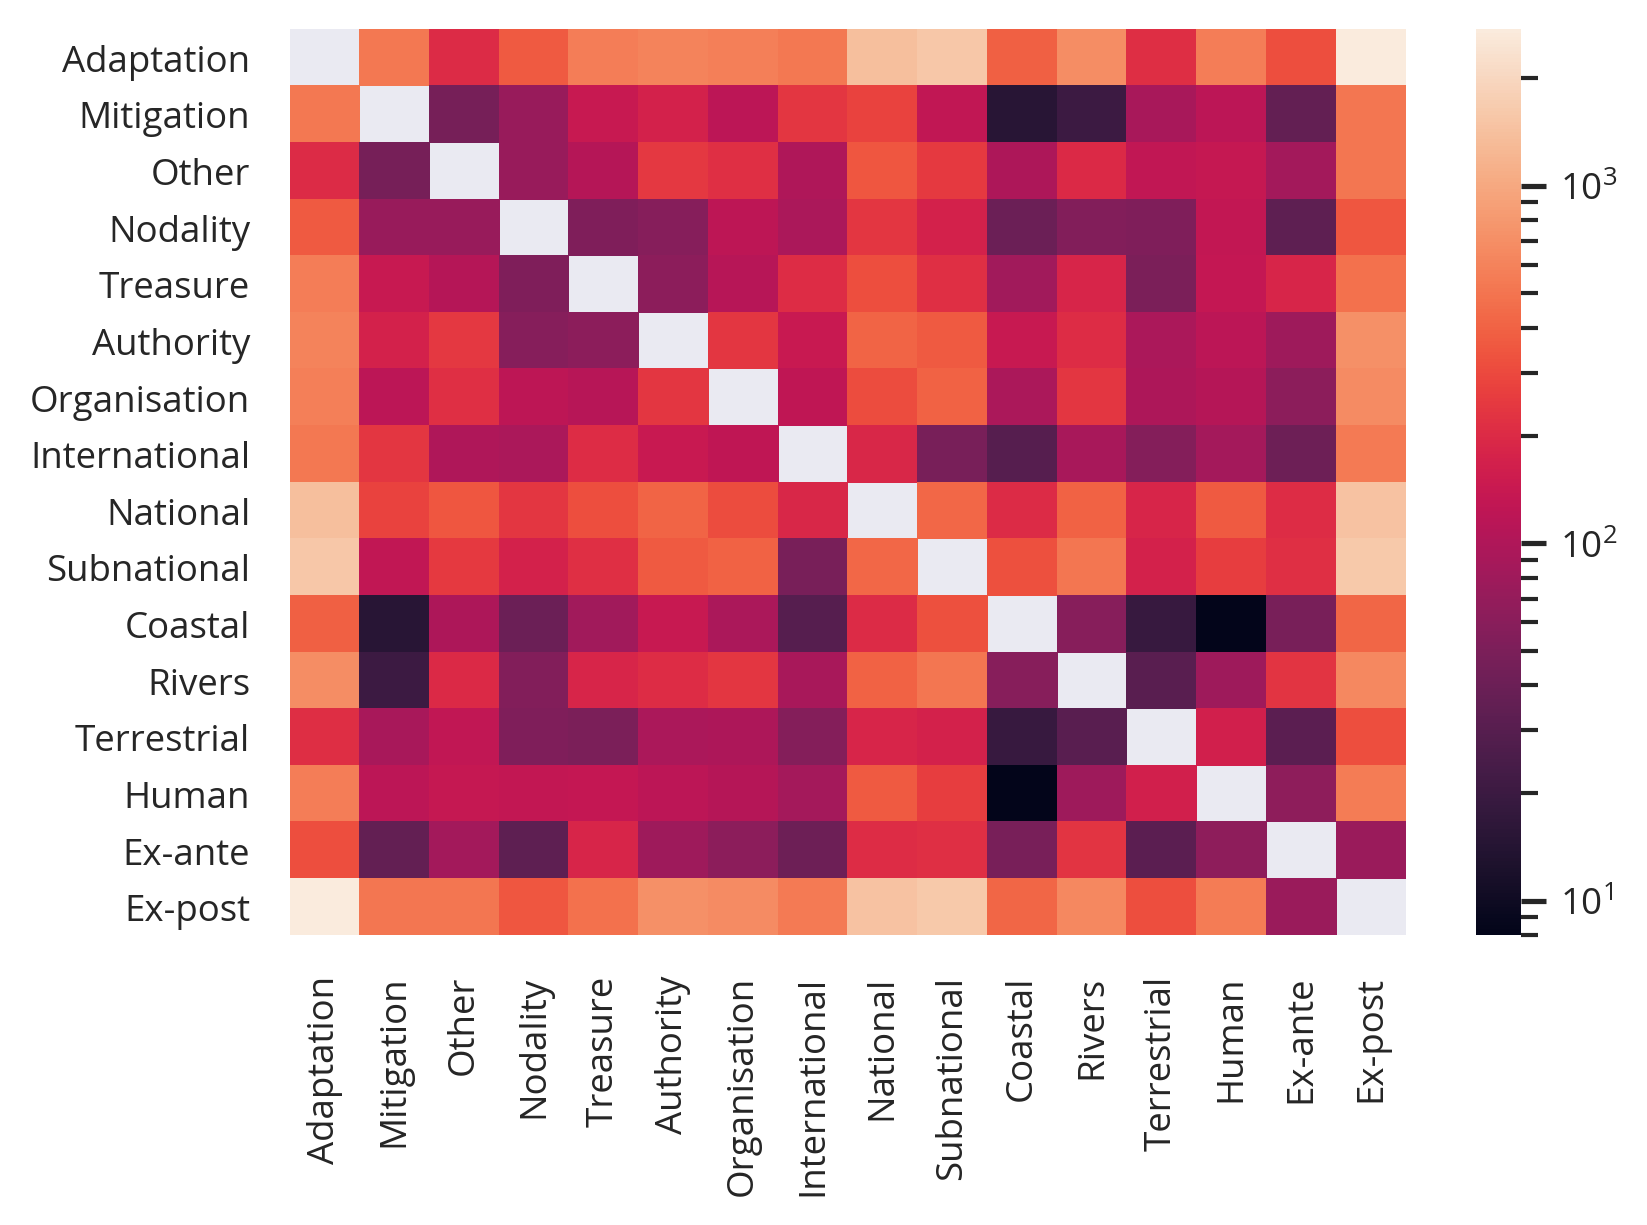

In [15]:
#Let's try all to start with
grid =  createGrid(classes, classes)

fig, ax = plt.subplots(dpi=300)
ax = sns.heatmap(grid, norm=LogNorm(),
               xticklabels = classes, yticklabels =classes,
                ax = ax)

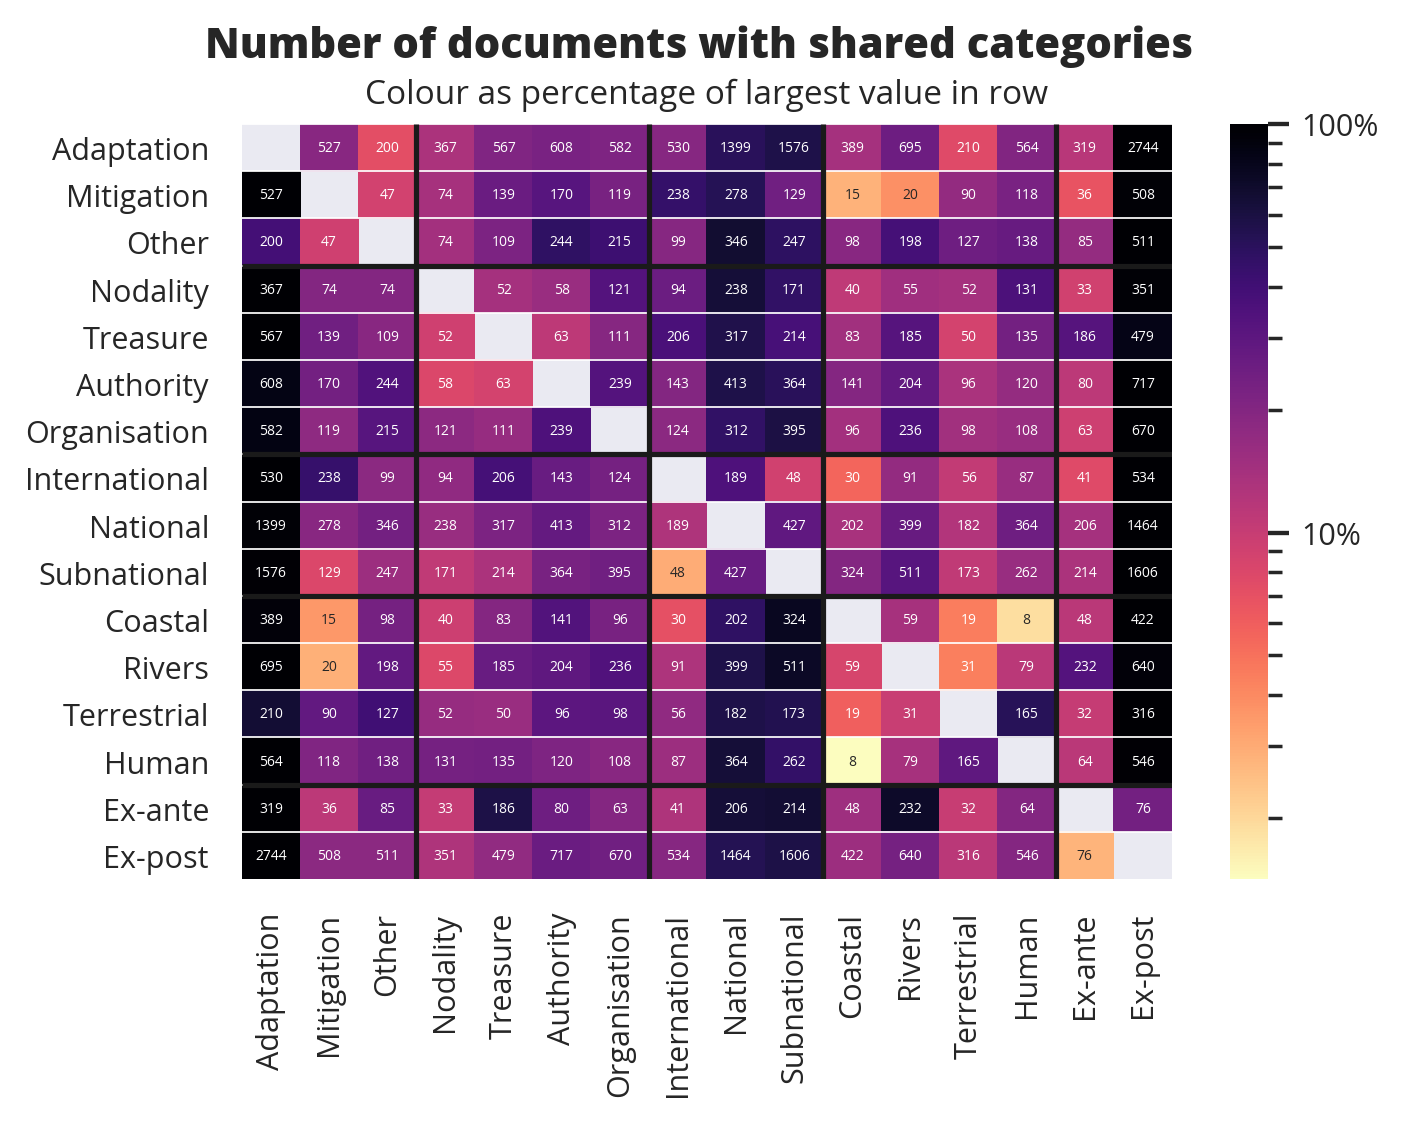

In [16]:
#Now normalise by row
gridNorm = normaliseGrid(grid, axis = 'row', percentage=True)

fig, ax = plt.subplots(dpi=250)
ax = sns.heatmap(gridNorm, 
                 norm=LogNorm(),
                 cmap = 'magma_r',
                 mask = grid==0,
                annot= grid, #Give absolute numbers as text
                 fmt= '.4g', annot_kws = {'fontsize':4},
                cbar_kws = {'format' : '%.0f%%'},            
                xticklabels = classes, yticklabels =classes )

plt.suptitle("Number of documents with shared categories", weight = 'bold', x=0.43 )
plt.title("Colour as percentage of largest value in row")

#Insert lines to make clear what direction of normalisation is and where categories end
ax.hlines(y=range(len(grid)), xmin=0, xmax = len(grid), linewidths= 0.5, colors='w')
ax.hlines(y=[3,7, 10, 14], xmin=0, xmax = len(grid))
ax.vlines(x=[3,7, 10, 14], ymin=0, ymax = len(grid))

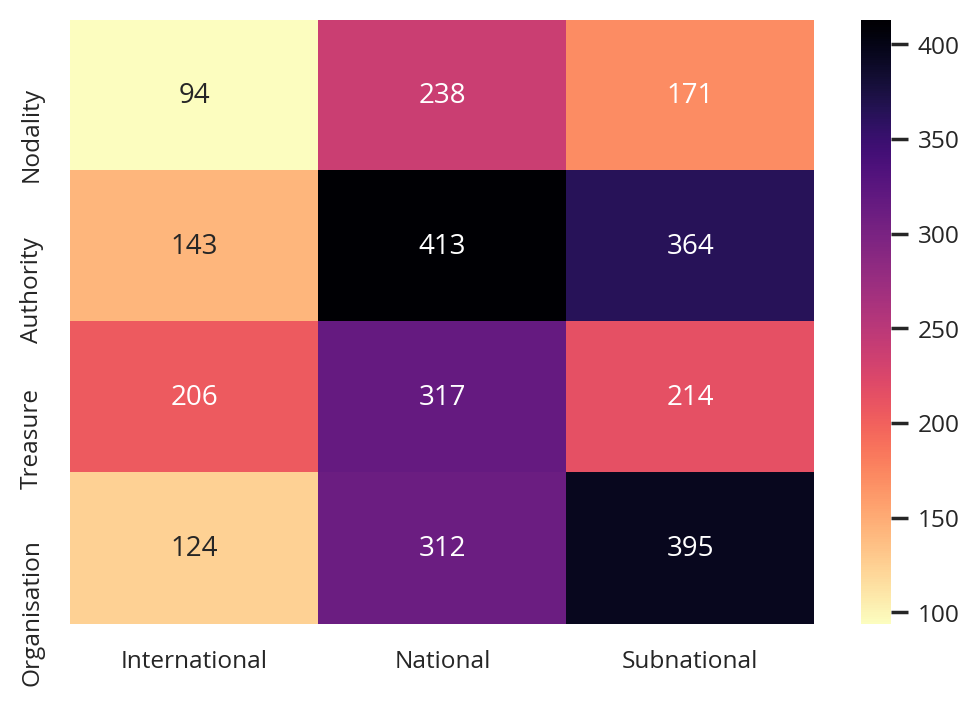

In [17]:
#Intstrument type vs level
nato = ['Nodality', 'Authority','Treasure', 'Organisation']
level = ['International', 'National', 'Subnational']

gridType = createGrid(nato, level)

fig, ax = plt.subplots(dpi=200)
sns.heatmap(gridType, #norm=LogNorm(),
            annot= True, fmt= '.3g',
            cmap='magma_r',
           xticklabels = level, yticklabels =nato )

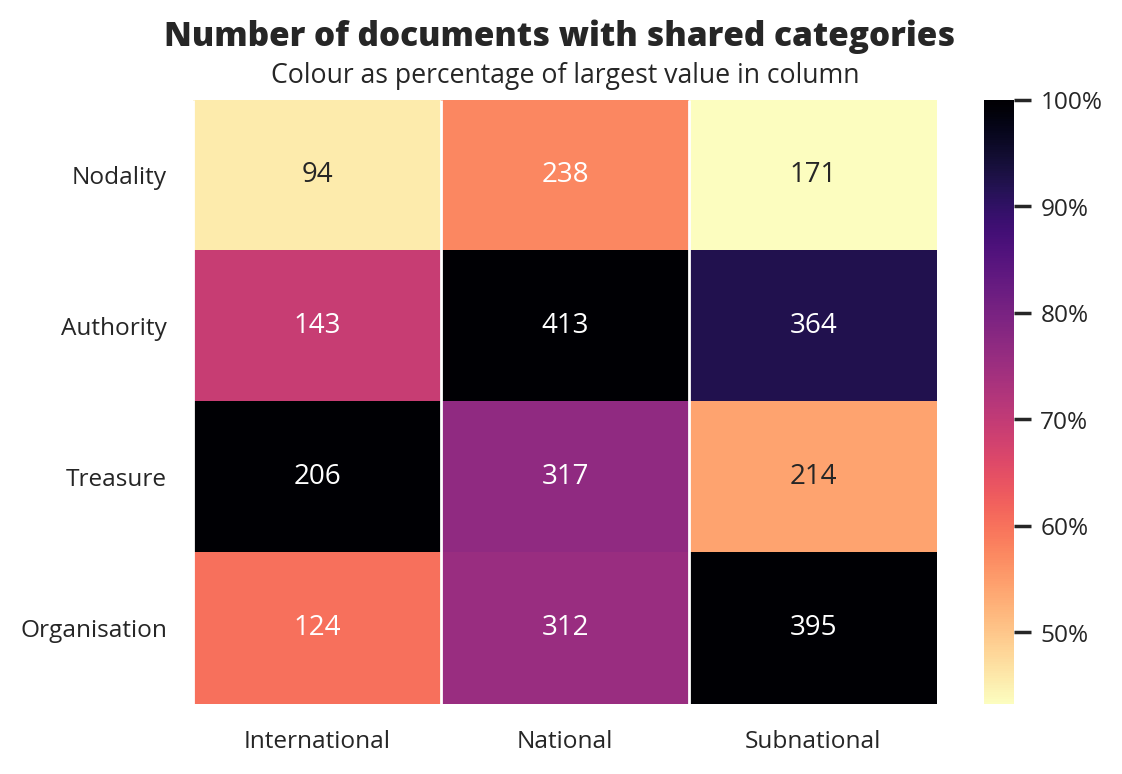

In [18]:
#Same but normalised
gridTypeNorm = normaliseGrid(gridType, axis = 'column', percentage=True)

fig, ax = plt.subplots(dpi=200)
sns.heatmap(gridTypeNorm, #norm=LogNorm(),
            annot= gridType, 
            cmap='magma_r',
            fmt= '.4g', annot_kws = {'fontsize':10},
            cbar_kws = {'format' : '%.0f%%'}, 
           xticklabels = level, yticklabels =nato)

plt.suptitle("Number of documents with shared categories", weight = 'bold', x=0.43 )
plt.title("Colour as percentage of largest value in column")

plt.yticks(rotation = 0)

#If adding the percentages as text
#for t in ax.texts: t.set_text(t.get_text() + " %")

ax.vlines(x=range(gridType.shape[1]), ymin=0, ymax = len(gridType), linewidths=1, colors='w')
ax.vlines(x=4, ymin=0, ymax = len(gridType))

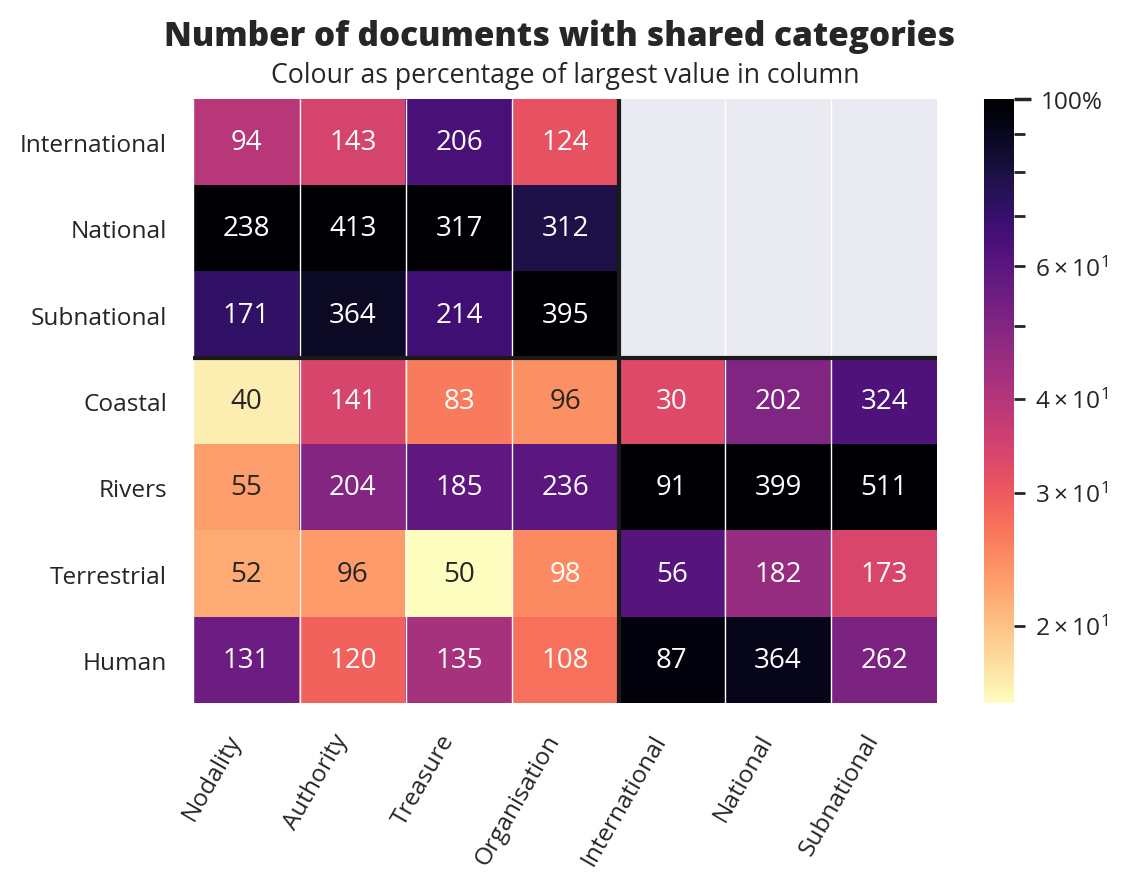

In [19]:
impact = ['Coastal','Rivers','Terrestrial','Human']

grid2 = createGrid(level + impact, nato + level)

#Create mask for level x level
mask = np.full(grid2.shape, False)
mask[:len(level), len(nato):] = True
            
#Normalize
grid2Norm = normaliseGrid(grid2, axis = 'column', percentage=True, mask=mask)
            
fig, ax = plt.subplots(dpi=200)
ax = sns.heatmap(grid2Norm, 
                 norm=LogNorm(),
                 mask = mask,
                annot= grid2, 
                cmap='magma_r',
                fmt= '.4g', annot_kws = {'fontsize':10},
                cbar_kws = {'format' : '%.0f%%'}, 
                xticklabels = nato + level, yticklabels =level + impact,
                )
#for t in ax.texts: t.set_text(t.get_text() + " %")
plt.suptitle("Number of documents with shared categories", weight = 'bold', x=0.43 )
plt.title("Colour as percentage of largest value in column")

plt.xticks(rotation = 60, ha='right')

ax.vlines(x=range(grid2.shape[1]), ymin=0, ymax = len(grid2), linewidths= 0.5, colors='w')
ax.vlines(x=4, ymin=0, ymax = len(grid))
ax.hlines(y=3, xmin=0, xmax = len(grid))

## Now let's combine categories with other document info
Starting with the geographic location

In [20]:
ldf = pd.read_csv('data/forGeoMap.csv', encoding='utf-8') #Not "forSTM.csv"; want to include multiple places in one text
print(ldf.shape)
ldf.head(5)

(12397, 68)


,Unnamed: 0,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,...,word,country_predicted,country_conf,Alpha-3,UN continental,UN statistical,Annex I or II,Code,Region,Income group
0,1115.0,1790670.0,The contributions of small local non-governmen...,The Voices of Local NGOs in Climate Change Iss...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.945330,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
1,1858.0,1987973.0,Climate actions are centered on either mitigat...,An assessment of potential synergies and trade...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.948191,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
2,3207.0,4918397.0,Background Nepal's 2015 earthquake and its aft...,Differential vulnerability and resilience of e...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepal,NPL,0.951695,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
3,5602.0,572578.0,BackgroundIn this paper we examine the role of...,The role of collective action in enhancing com...,NaN,NaN,NaN,0.0,0.0,0.0,...,Nepalgunj,NPL,0.893303,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income
4,7111.0,450978.0,Nepal is one of the 20 most disaster-prone cou...,Women's Empowerment in Building Disaster Resil...,NaN,NaN,NaN,0.0,0.0,0.0,...,Rautahat,NPL,0.930774,NPL,Asia,Southern Asia,Non-Annex I,NPL,South Asia,Lower middle income


In [21]:
gdf = pd.merge(cdf, ldf[['id','word', 'country_predicted', 'UN continental', 'UN statistical']], how='left', on='id')
print(ldf.shape)

gdf = gdf[~gdf['UN continental'].isna()] #Drop without any place
print(gdf.shape)
#Multiple mentions in same country are also dropped; if two countries in one text, counted separately
gdf.drop_duplicates(subset=['id', 'country_predicted'], inplace=True) 
print(gdf.shape)

gdf.head()

(12397, 68)
(6894, 28)
(5971, 28)


,id,title,content,PY,seen,random,include_score,Adaptation,Mitigation,Other,...,Rivers,Terrestrial,Human,Ex-ante,Ex-post,MaxCat,word,country_predicted,UN continental,UN statistical
1,3286707,Vulnerability to global environmental changes:...,The purpose of this paper is to demonstrate th...,2018.0,NaN,NaN,0.587677,0.030497,0.003366,0.003145,...,0.005188,0.004376,0.022849,0.003031,0.012849,No prediction,Brazil,BRA,Americas,South America
3,1047270,Women's Empowerment and Climate Change Adaptat...,(1) As on-the-ground projects come into existe...,2018.0,NaN,NaN,0.948534,0.622924,0.003628,0.018892,...,0.003763,0.004649,0.016103,0.002465,0.052423,Adaptation,Gujarat,IND,Asia,Southern Asia
4,770190,Climatic and Environmental Changes Affecting C...,Small rural coastal communities located in Atl...,2017.0,NaN,NaN,0.866686,0.814135,0.004539,0.028920,...,0.044223,0.035439,0.026959,0.008394,0.801332,Adaptation,Quebec,CAN,Americas,Northern America
7,761149,Addressing challenges for future strategic-lev...,The mounting frequency and intensity of natura...,2017.0,NaN,NaN,0.991218,0.438084,0.005707,0.002748,...,0.010176,0.007345,0.014548,0.009799,0.996416,Adaptation,Australia,AUS,Oceania,Australia and New Zealand
8,4383180,The Resilience of Inter-basin Transfers to Sev...,Faced with the prospect of climate change and ...,2020.0,NaN,NaN,0.854528,0.058960,0.002442,0.003918,...,0.730048,0.019223,0.033385,0.992413,0.010599,No prediction,Southern England,GBR,Europe,Northern Europe


In [22]:
gdf['country_predicted'].value_counts()

USA    963
AUS    390
CAN    272
CHN    249
IND    227
      ... 
SHN      1
TGO      1
ATG      1
BEN      1
OMN      1
Name: country_predicted, Length: 190, dtype: int64

In [23]:
#Split up the Americas
gdf['continentAS'] = gdf['UN continental']
gdf.loc[gdf['country_predicted'].isin(['USA', 'CAN', 'MEX']), 'continentAS'] = 'North America'
gdf.loc[gdf['continentAS'] == 'Americas', 'continentAS']= 'South America'

In [24]:
#The previous way to create grids does not work as this is location is one categorical str column
def createGridGeos(xclasses, ycolumn, ysubset = None, cdf=gdf, flip=False):
    if type(ysubset) != None:
        yclasses = ysubset
    else:     
        yclasses = cdf[ycolumn].unique()
        
    grid = np.zeros((len(xclasses), len(yclasses)))
    for i, col in enumerate(xclasses):
        for j, place in enumerate(yclasses): 
            #Select where the predicted relevance for class is >.5 and the place matches
            grid[i, j] = cdf[(cdf[col] > 0.5) & (cdf[ycolumn] == place)].shape[0]
    
    if flip: 
        return(grid.T)
    else:
        return(grid)

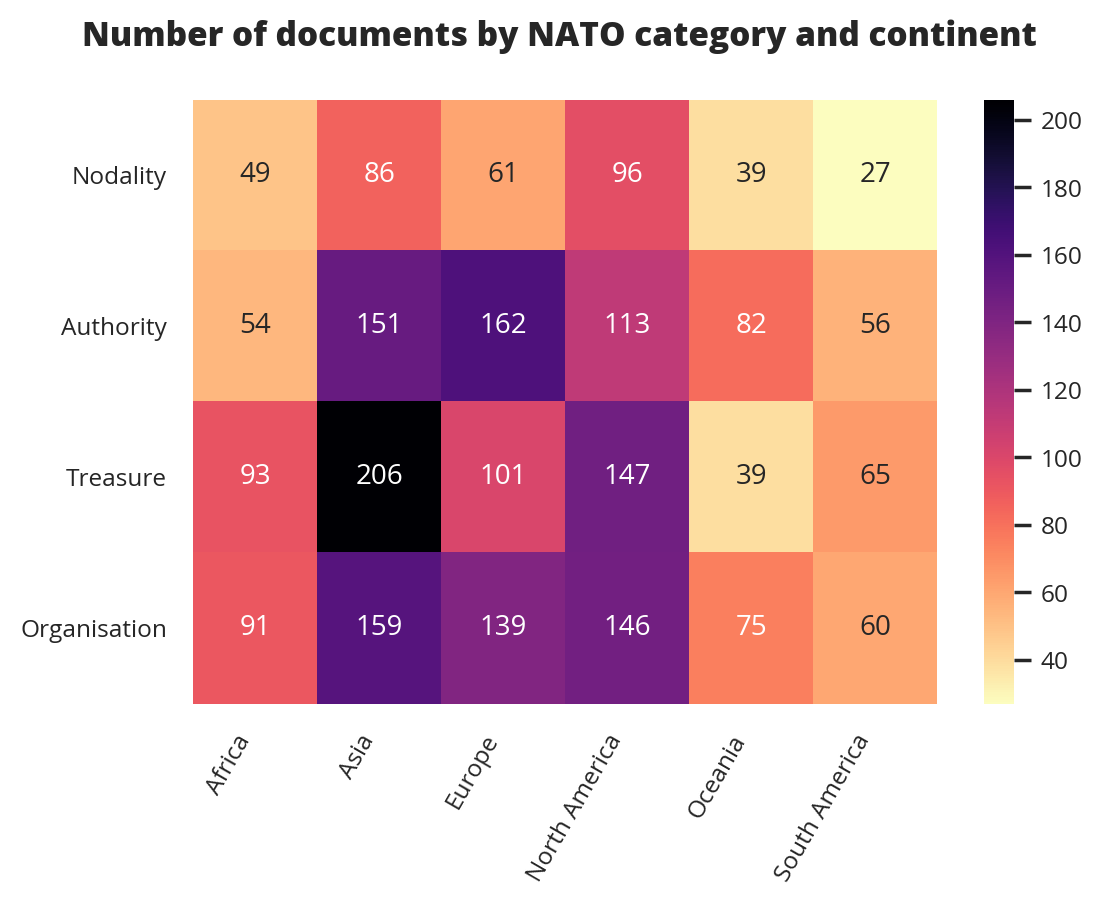

In [25]:
nato = ['Nodality', 'Authority','Treasure', 'Organisation']
continents = gdf['continentAS'].unique()
continents = np.sort(continents[continents != 'Antartica'])

contGrid = createGridGeos(nato, 'continentAS', ysubset = continents)

fig, ax = plt.subplots(dpi=200)
sns.heatmap(contGrid, #norm=LogNorm(),
            annot= True, fmt= '.3g',
            cmap='magma_r',
           xticklabels = continents, yticklabels =nato )
plt.yticks(rotation=0)
plt.xticks(rotation=60, ha='right')
plt.suptitle("Number of documents by NATO category and continent", weight = 'bold', x=0.43 )
#plt.title("Colour as percentage of largest value in column")

plt.show()

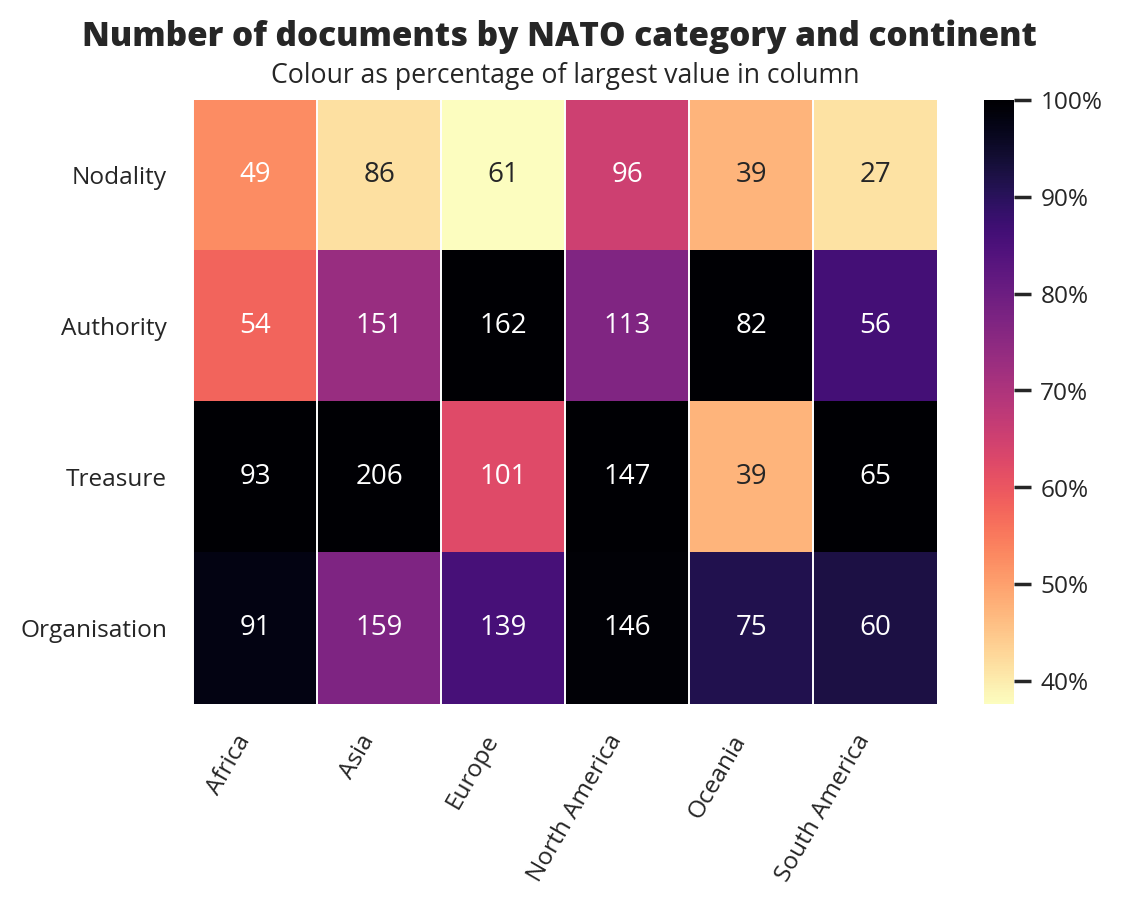

In [26]:
contGridNorm = normaliseGrid(contGrid, axis = 'column', percentage=True)

fig, ax = plt.subplots(dpi=200)
sns.heatmap(contGridNorm, #norm=LogNorm(),
            annot= contGrid, 
            fmt= '.3g',
            cmap='magma_r',
            cbar_kws = {'format' : '%.0f%%'},
            xticklabels = continents, yticklabels =nato )

plt.yticks(rotation=0)
plt.xticks(rotation=60, ha='right')

ax.vlines(x=range(contGrid.shape[1]), ymin=0, ymax = len(contGrid), linewidths= 0.7, colors='w')
#ax.vlines(x=4, ymin=0, ymax = len(contGrid))
#ax.hlines(y=3, xmin=0, xmax = len(contGrid))

plt.suptitle("Number of documents by NATO category and continent", weight = 'bold', x=0.43 )
plt.title("Colour as percentage of largest value in column")

plt.show()

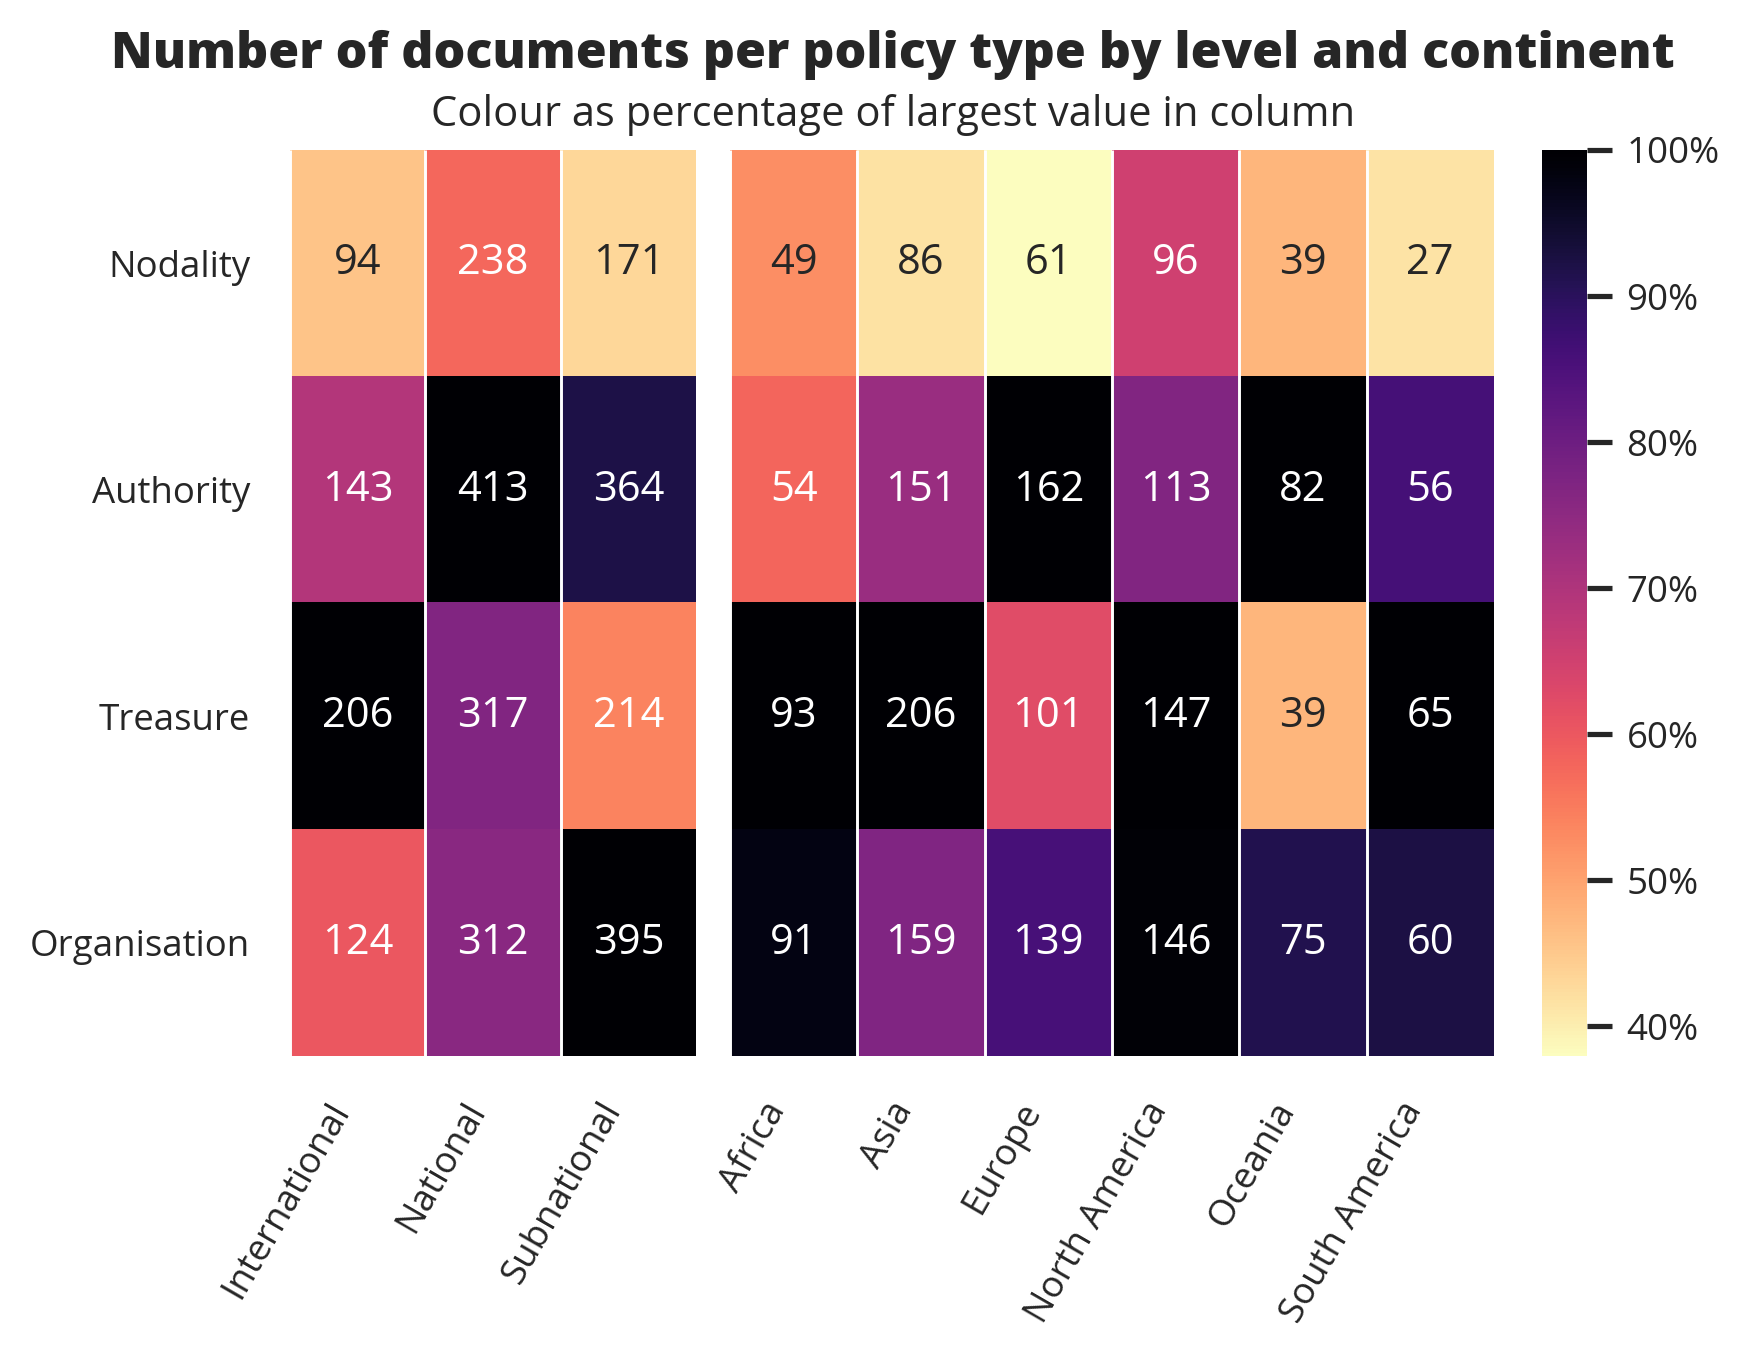

In [27]:
#Combine continents with the level
fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 300, sharey = True,
                              gridspec_kw={'width_ratios': [1, 2.35]})

ax1 = sns.heatmap(gridTypeNorm, #norm=LogNorm(),
            annot= gridType, 
            cmap='magma_r',
            fmt= '.4g', annot_kws = {'fontsize':10},
            cbar = False, 
            vmin = 38, vmax=100,
            xticklabels = level, yticklabels =nato,
            ax = ax1)

ax2 = sns.heatmap(contGridNorm, #norm=LogNorm(),
            annot= contGrid, 
            fmt= '.3g',
            cmap='magma_r',
            cbar_kws = {'format' : '%.0f%%'},
            vmin = 38, vmax=100,
            xticklabels = continents, yticklabels =nato ,
            ax = ax2)

plt.yticks(rotation=0)
plt.xticks(rotation=60, ha='right')
plt.sca(ax1)
plt.xticks(rotation=60, ha='right')
plt.yticks(rotation=0)

ax1.vlines(x=range(gridTypeNorm.shape[1]), ymin=0, ymax = len(contGrid), linewidths= 0.7, colors='w')
ax2.vlines(x=range(contGridNorm.shape[1]), ymin=0, ymax = len(contGridNorm), linewidths= 0.7, colors='w')

plt.suptitle("Number of documents per policy type by level and continent", weight = 'bold', x=0.46)
fig.text(0.46,0.9, "Colour as percentage of largest value in column", ha='center')

plt.subplots_adjust(wspace=0.05)

fig.patch.set_facecolor("white")

plt.show()
